# Customer Segmentation Project — Online Retail II

This notebook performs customer segmentation using unsupervised learning and is tailored to the `online_retail_II.csv` dataset you uploaded.

Sections:
- Setup
- Inspection & cleaning
- Feature engineering (RFM + extras)
- Preprocessing (outliers & scaling)
- Clustering (KMeans, Hierarchical, DBSCAN)
- Cluster profiling & labeling
- Visualization (PCA, t-SNE)
- Streamlit dashboard scaffold (full .py included)
- Business insights & deliverables


In [1]:
# 1. Setup - import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
import joblib
import os
from scipy import stats

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score

import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 200)

# File path - adjust if your CSV is elsewhere
DATA_PATH = 'data/online_retail_II.csv'
assert os.path.exists(DATA_PATH), f"File not found: {DATA_PATH}"

df = pd.read_csv(DATA_PATH, encoding='latin1')
print('Loaded', df.shape, 'rows and columns')
df.head()


Loaded (1067371, 8) rows and columns


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [2]:
# 2. Initial inspection & null values
print('Null counts:')
print(df.isna().sum())
print('\nInfo:')
print(df.info())
print('\nDescribe (numerical):')
display(df.describe().T)


Null counts:
Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
dtype: int64

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB
None

Describe (numerical):


,count,mean,std,min,25%,50%,75%,max
Quantity,1067371.0,9.938898,172.705794,-80995.00,1.00,3.0,10.00,80995.0
Price,1067371.0,4.649388,123.553059,-53594.36,1.25,2.1,4.15,38970.0
Customer ID,824364.0,15324.638504,1697.464450,12346.00,13975.00,15255.0,16797.00,18287.0


In [3]:
# 3. Cleaning strategy (applied)
df_clean = df.copy()
before = len(df_clean)
df_clean = df_clean.dropna(subset=['Customer ID'])
after = len(df_clean)
print(f'Dropped {before-after} rows without Customer ID')

# Fill Description
df_clean['Description'] = df_clean['Description'].fillna('Unknown')

# Convert Customer ID to int
df_clean['Customer ID'] = df_clean['Customer ID'].astype(int)

# Convert InvoiceDate
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'], errors='coerce')
print('Min/Max InvoiceDate:', df_clean['InvoiceDate'].min(), df_clean['InvoiceDate'].max())

# Remove non-positive quantities and prices
neg_qty = (df_clean['Quantity'] <= 0).sum()
neg_price = (df_clean['Price'] <= 0).sum()
print(f'Rows with non-positive Quantity: {neg_qty}, non-positive Price: {neg_price}')
df_clean = df_clean[(df_clean['Quantity'] > 0) & (df_clean['Price'] > 0)].copy()

# Drop exact duplicates
dups = df_clean.duplicated().sum()
print('Duplicate rows:', dups)
df_clean = df_clean.drop_duplicates()

print('Shape after cleaning:', df_clean.shape)


Dropped 243007 rows without Customer ID
Min/Max InvoiceDate: 2009-12-01 07:45:00 2011-12-09 12:50:00
Rows with non-positive Quantity: 18744, non-positive Price: 71
Duplicate rows: 26124
Shape after cleaning: (779425, 8)


In [4]:
# 4. Feature Engineering — aggregate to customer level
df_clean['TotalPrice'] = df_clean['Quantity'] * df_clean['Price']
snapshot_date = df_clean['InvoiceDate'].max() + pd.Timedelta(days=1)
print('Snapshot date (for Recency):', snapshot_date.date())

agg_funcs = {
    'InvoiceDate': ['min', 'max'],
    'Invoice': 'nunique',
    'Quantity': 'sum',
    'TotalPrice': 'sum',
    'StockCode': 'nunique',
}
cust = df_clean.groupby('Customer ID').agg(agg_funcs)
cust.columns = ['first_purchase', 'last_purchase', 'num_invoices', 'total_quantity', 'monetary', 'distinct_products']

cust['recency_days'] = (snapshot_date - cust['last_purchase']).dt.days
cust['frequency'] = cust['num_invoices']
cust['avg_basket_value'] = cust['monetary'] / cust['num_invoices']
cust['avg_qty_per_invoice'] = cust['total_quantity'] / cust['num_invoices']

cust.replace([np.inf, -np.inf], np.nan, inplace=True)
cust.fillna(0, inplace=True)
cust.reset_index(inplace=True)
print('Customer aggregated shape:', cust.shape)
cust.head()


Snapshot date (for Recency): 2011-12-10
Customer aggregated shape: (5878, 11)


,Customer ID,first_purchase,last_purchase,num_invoices,total_quantity,monetary,distinct_products,recency_days,frequency,avg_basket_value,avg_qty_per_invoice
0,12346,2009-12-14 08:34:00,2011-01-18 10:01:00,12,74285,77556.46,27,326,12,6463.038333,6190.416667
1,12347,2010-10-31 14:20:00,2011-12-07 15:52:00,8,2967,4921.53,126,2,8,615.191250,370.875000
2,12348,2010-09-27 14:59:00,2011-09-25 13:13:00,5,2714,2019.40,25,75,5,403.880000,542.800000
3,12349,2010-04-29 13:20:00,2011-11-21 09:51:00,4,1624,4428.69,138,19,4,1107.172500,406.000000
4,12350,2011-02-02 16:01:00,2011-02-02 16:01:00,1,197,334.40,17,310,1,334.400000,197.000000


In [5]:
# Save aggregated table for dashboard use
cust.to_csv('customer_aggregates.csv', index=False)
print('Saved customer_aggregates.csv')


Saved customer_aggregates.csv


In [6]:
# 5. Preprocessing — outliers & scaling
features = ['recency_days', 'frequency', 'monetary', 'avg_basket_value', 'avg_qty_per_invoice', 'distinct_products']
X = cust[features].copy()

# Log-transform skewed monetary features
X['monetary_log'] = np.log1p(X['monetary'])
X['avg_basket_value_log'] = np.log1p(X['avg_basket_value'])
X['frequency_log'] = np.log1p(X['frequency'])

X_prep = X[['recency_days', 'frequency_log', 'monetary_log', 'avg_basket_value_log', 'avg_qty_per_invoice', 'distinct_products']].copy()

# Winsorize using IQR capping function
def cap_iqr(series, k=1.5):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - k * iqr
    upper = q3 + k * iqr
    return series.clip(lower, upper)

X_wins = X_prep.apply(cap_iqr)

scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_wins)

joblib.dump(scaler, 'scaler_customer_seg.pkl')
print('Scaled matrix shape:', X_scaled.shape)


Scaled matrix shape: (5878, 6)


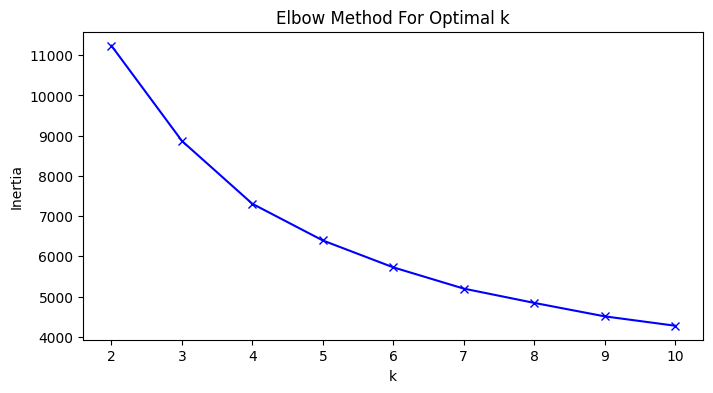

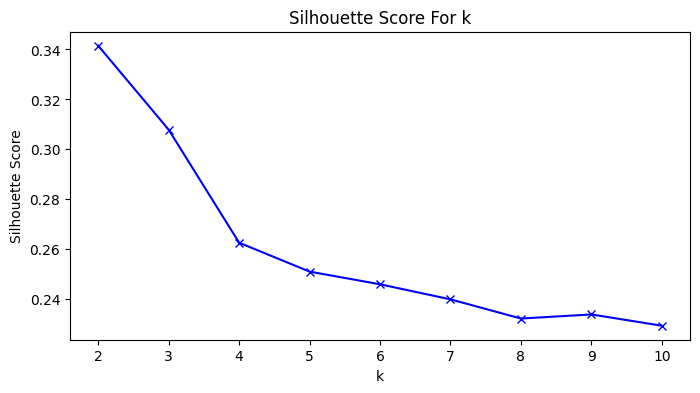

In [7]:
# 6. Determine optimal number of clusters (Elbow + Silhouette)
inertia = []
K = range(2, 11)
for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.figure(figsize=(8,4))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

sil_scores = []
for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    sil_scores.append(silhouette_score(X_scaled, labels))

plt.figure(figsize=(8,4))
plt.plot(K, sil_scores, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score For k')
plt.show()


In [8]:
# 7. Clustering: KMeans, Hierarchical, DBSCAN
# Choose k based on previous plots; default to 4 but inspect plots to change
k = 4
kmeans = KMeans(n_clusters=k, random_state=42, n_init=30)
cust['kmeans_cluster'] = kmeans.fit_predict(X_scaled)
joblib.dump(kmeans, 'kmeans_customer_seg.pkl')

agg = AgglomerativeClustering(n_clusters=k)
cust['agg_cluster'] = agg.fit_predict(X_scaled)

# DBSCAN — tune eps/min_samples; here we attempt a default and show counts
db = DBSCAN(eps=0.5, min_samples=5)
cust['dbscan_cluster'] = db.fit_predict(X_scaled)

print('Cluster counts (KMeans):')
print(cust['kmeans_cluster'].value_counts())
print('\nCluster counts (Agglomerative):')
print(cust['agg_cluster'].value_counts())
print('\nCluster counts (DBSCAN):')
print(cust['dbscan_cluster'].value_counts())

cust.to_csv('customer_aggregates_with_clusters.csv', index=False)
print('Saved customer_aggregates_with_clusters.csv')


Cluster counts (KMeans):
kmeans_cluster
2    2084
0    1794
1    1093
3     907
Name: count, dtype: int64

Cluster counts (Agglomerative):
agg_cluster
0    1943
1    1867
3    1350
2     718
Name: count, dtype: int64

Cluster counts (DBSCAN):
dbscan_cluster
 0    5627
-1     243
 1       8
Name: count, dtype: int64
Saved customer_aggregates_with_clusters.csv


In [9]:
# 8. Cluster profiling
profile_features = ['recency_days', 'frequency', 'monetary', 'avg_basket_value', 'avg_qty_per_invoice', 'distinct_products']
profile = cust.groupby('kmeans_cluster')[profile_features].agg(['mean','median','count']).T
display(profile)

# Create readable cluster labels based on inspection (edit after running)
cluster_map = {i: f'Cluster {i}' for i in cust['kmeans_cluster'].unique()}
cust['kmeans_label'] = cust['kmeans_cluster'].map(cluster_map)

profile.to_csv('kmeans_cluster_profile.csv')
print('Saved kmeans_cluster_profile.csv')


kmeans_cluster                        0             1            2            3
recency_days        mean     366.430881     52.303751   131.111324   215.708931
                    median   393.000000     22.000000    64.000000   130.000000
                    count   1794.000000   1093.000000  2084.000000   907.000000
frequency           mean       1.681717     18.794145     4.743762     3.885336
                    median     1.000000     12.000000     4.000000     2.000000
                    count   1794.000000   1093.000000  2084.000000   907.000000
monetary            mean     255.260067  10036.820090  1290.469197  3591.274028
                    median   220.675000   4783.660000   975.485000  1522.750000
                    count   1794.000000   1093.000000  2084.000000   907.000000
avg_basket_value    mean     168.183571    466.234950   304.581731   901.905767
                    median   151.300000    372.215455   275.433250   599.680000
                    count   1794.000000   1093.000000  2084.000000   907.000000
avg_qty_per_invoice mean      92.319640    272.515022   152.979466   741.840814
                    median    80.000000    219.428571   145.291667   405.500000
                    count   1794.000000   1093.000000  2084.000000   907.000000
distinct_products   mean      18.711260    249.252516    57.393474    62.098126
                    median    14.000000    203.000000    50.000000    53.000000
                    count   1794.000000   1093.000000  2084.000000   907.000000

Saved kmeans_cluster_profile.csv


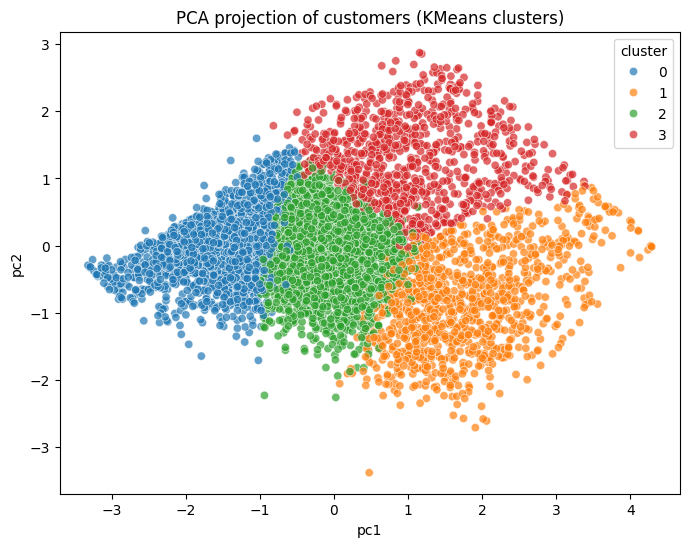

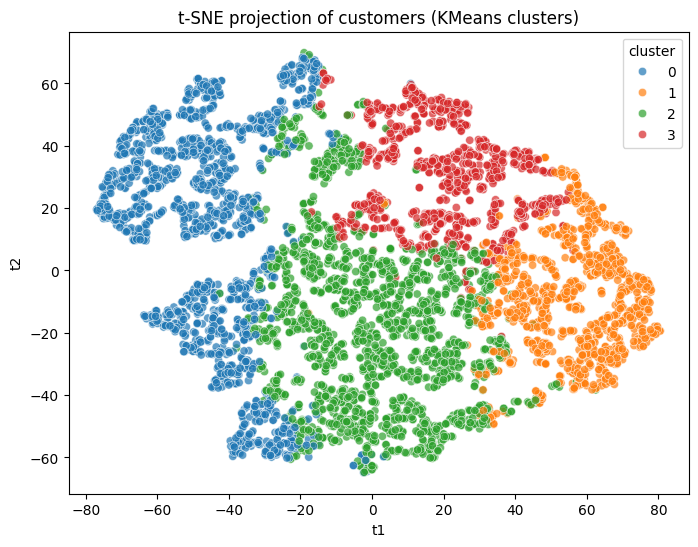

In [11]:
# 9. Visualization — PCA & t-SNE
pca = PCA(n_components=2, random_state=42)
pca_proj = pca.fit_transform(X_scaled)
viz_df = pd.DataFrame(pca_proj, columns=['pc1','pc2'])
viz_df['cluster'] = cust['kmeans_cluster'].values
viz_df['label'] = cust['kmeans_label'].values

plt.figure(figsize=(8,6))
sns.scatterplot(data=viz_df, x='pc1', y='pc2', hue='cluster', palette='tab10', alpha=0.7)
plt.title('PCA projection of customers (KMeans clusters)')
plt.show()

# t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
tsne_proj = tsne.fit_transform(X_scaled)
viz_df2 = pd.DataFrame(tsne_proj, columns=['t1','t2'])
viz_df2['cluster'] = cust['kmeans_cluster'].values

plt.figure(figsize=(8,6))
sns.scatterplot(data=viz_df2, x='t1', y='t2', hue='cluster', palette='tab10', alpha=0.7)
plt.title('t-SNE projection of customers (KMeans clusters)')
plt.show()

# Interactive Plotly
fig = px.scatter(viz_df, x='pc1', y='pc2', color='label', hover_data=['cluster'])
fig.show()


## Business insights & Marketing recommendations

After inspecting cluster profiles, assign descriptive labels. Example recommendations:
- **High-Value Loyalists**: retention campaigns, VIP offers, referral programs.
- **Bargain Hunters**: coupons, discounts, clearance sales.
- **One-time Shoppers**: targeted recommendations, personalized emails, first-purchase discounts.
- **At-Risk**: win-back campaigns, feedback requests, limited-time incentives.

Include A/B testing plans to measure campaign impact, and a data engineering plan to schedule aggregation jobs (Airflow), store aggregates in a data warehouse, and maintain data quality checks.


## Streamlit Dashboard (scaffold provided in `streamlit_app.py`)

The Streamlit app uses `customer_aggregates_with_clusters.csv` (generated earlier). Launch with:
```
streamlit run streamlit_app.py
```


In [12]:
# 10. Save final artifacts
cust.to_csv('customer_aggregates_with_clusters.csv', index=False)
print('All artifacts saved: customer_aggregates.csv, customer_aggregates_with_clusters.csv, kmeans_cluster_profile.csv, scaler_customer_seg.pkl, kmeans_customer_seg.pkl')


All artifacts saved: customer_aggregates.csv, customer_aggregates_with_clusters.csv, kmeans_cluster_profile.csv, scaler_customer_seg.pkl, kmeans_customer_seg.pkl
